# Kernel logistic regression

- We will implement kernel logistic regression de novo using numpy and scipy
- all required imports have been added for you in cell 1
- here is the workflow:
   - generate 200 points on the plane in an XOR configuration and visualize it
   - build a kernel logistic model for three cases (1) ALL 200 points as landmarks, (2) landmarks chosen by kmeans clustering, (3) 4 strategically chosen landmarks
   - Test the model in each case as follows
       -create a grid of 50 x 50 test points on [-3,+3] x [-3,+3]
       - build a kernel representation of the 2500 test points 
       - use fitted logistic model to predict probability of membership in class 1 for the 2500 points
       - reshape prediction array into a 50x50 array for plotting

In [285]:
import numpy as np
import pandas as pd
import sklearn as sklearn
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots

In [286]:
# function for plotting the decision boundaries
# Z = prediction array reshaped as 50x50, X and y which are the original training data, 
# xx and yy are the grid coordinates for the test points

def plot_boundary(Z,X,Y,xx,yy):
    image = plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0.5], linewidths=2,colors=['k'])
    plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired,edgecolors=(0, 0, 0))
    plt.xticks(())
    plt.yticks(())
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)

## Generate and visualize XOR data for training

In [287]:
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
print(X.shape,y.shape)

(200, 2) (200,)


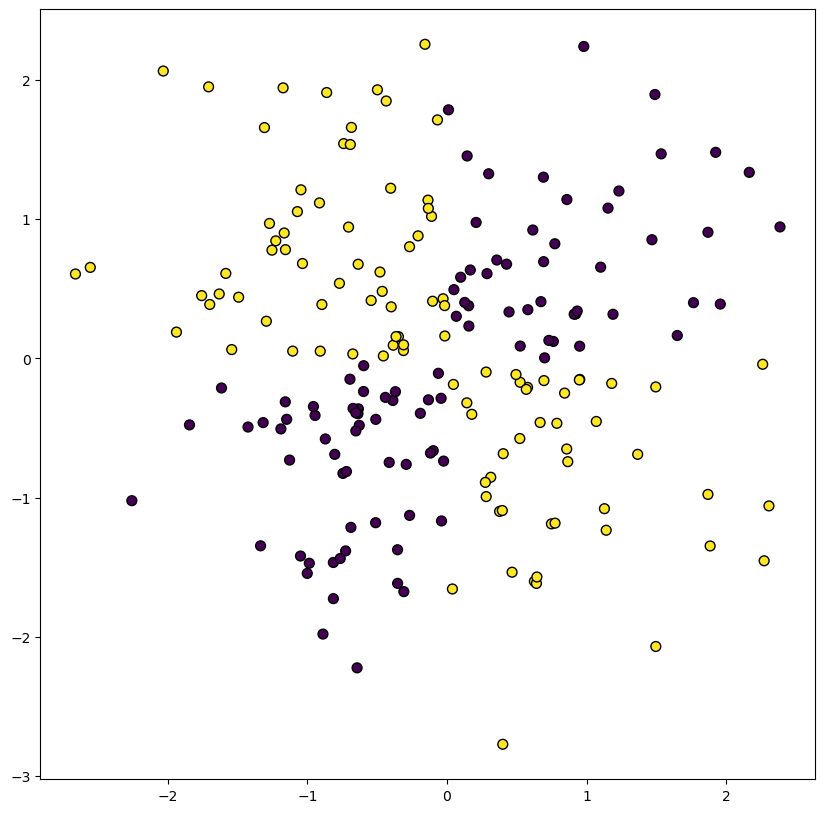

In [288]:
plt.scatter(X[:, 0], X[:, 1], s=50, c=y, cmap=plt.cm.viridis, edgecolors=(0, 0, 0))

## Generate a grid of 50x50 points for testing

In [289]:
# build the testpoints 
xx, yy = np.meshgrid(np.linspace(-3, 3, 50),np.linspace(-3, 3, 50))
test_points = np.vstack((xx.ravel(), yy.ravel())).T
print(xx.shape,yy.shape,test_points.shape)

(50, 50) (50, 50) (2500, 2)


## Do kernel regression using all the points as landmarks
- use the Gaussian kernel exp(-||x-x'||^2/2s^2) where s is the kernel width
- construct the kernel matrix K (hint: the function pdist in scipy.spatial.distance might be helpful). Use euclidean distance as your metric. Ignore the bias term (column of 1s) in the construction of K. So K will be of size 200 x 200
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html#scipy.spatial.distance.squareform (to convert pdist matrix to square)
- build a logistic regresion model using K as your data matrix and y as your label vector (use defaults for the LogisticRegression() call).
   - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- construct the kernel matrix corresponding to the test points using the training set landmarks (see cdist)
   - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
- predict class probabilities for the test points (use .predict_proba() for the logistic classifier)
- reshape the predicted values array into a 50x50 grid
- plot the decision boundary using the given function

In [290]:
##### START YOUR CODE
s = 2.0 # kernel width (you can play with this parameter)

# build the kernel matrix on training data (about 2 lines of vectorized code)
pairwise_distances = pdist(X, metric='euclidean')
K = squareform(pairwise_distances)
K = np.exp(-K**2 / (2 * s**2))

# build a logistic model on the kernel matrix (2 lines of code) using sklearn's LogisticRegression()
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(K, y)

# construct the kernel representation of the test_points with the training set landmarks (see cdist)
# hint: consider using cdist in scipy.spatial.distance (about 2-3 lines of code)
test_kernel_matrix = np.exp(-cdist(test_points, X, metric='euclidean')**2 / (2 * s**2))
class_probabilities = logistic_regression_model.predict_proba(test_kernel_matrix)
class_probabilities_grid = class_probabilities[:, 1].reshape(xx.shape)

# use your learned model to predict using the kernel representation.
# Store the predictions in array Z (1 line of code)
Z = logistic_regression_model.predict(test_kernel_matrix)

##### END YOUR CODE

# reshape Z into a 50x50 grid
Z = Z.reshape(xx.shape)

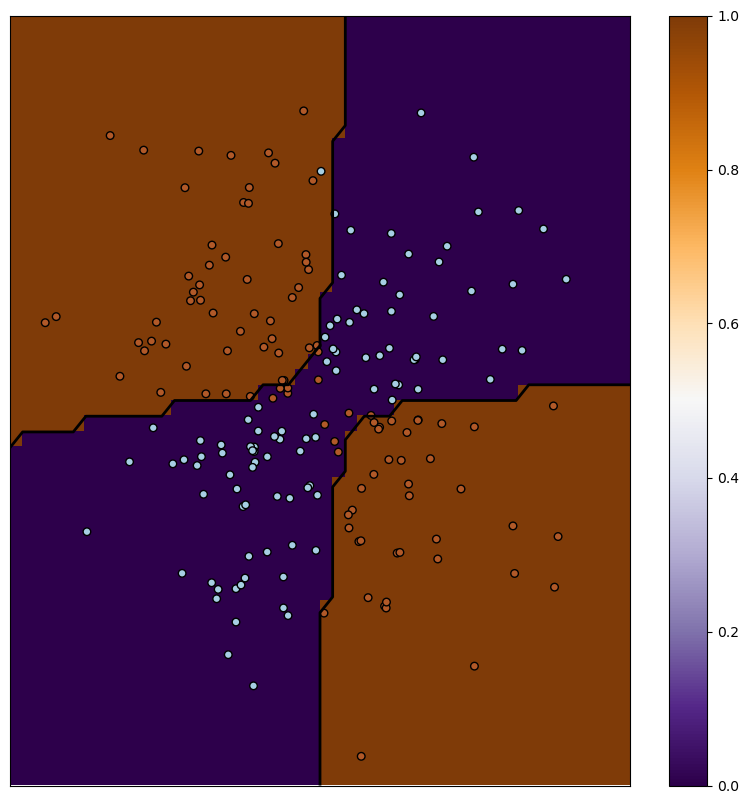

In [291]:
plot_boundary(Z,X,y,xx,yy)

## Kernel regression using clustering to select landmarks
- run Kmeans on the original data to build N clusters (N=30). You can vary this and study its impact.
- Use the cluster centers as landmarks for building the kernel representation. That is, construct the kernel matrix K (hint: the function cdist in scipy.spatial.distance might be helpful). Use euclidean distance as your metric. Ignore the bias term (column of 1s) in the construction of K. So K will be of size N x N
- build a logistic regresion model using K as your data matrix and y as your label vector
- construct the kernel matrix corresponding to the test points using the training set landmarks (using cdist)
- predict class probabilities for the test points
- reshape the predicted values array into a 50x50 grid
- plot the decision boundary using the given function

(200, 2)


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


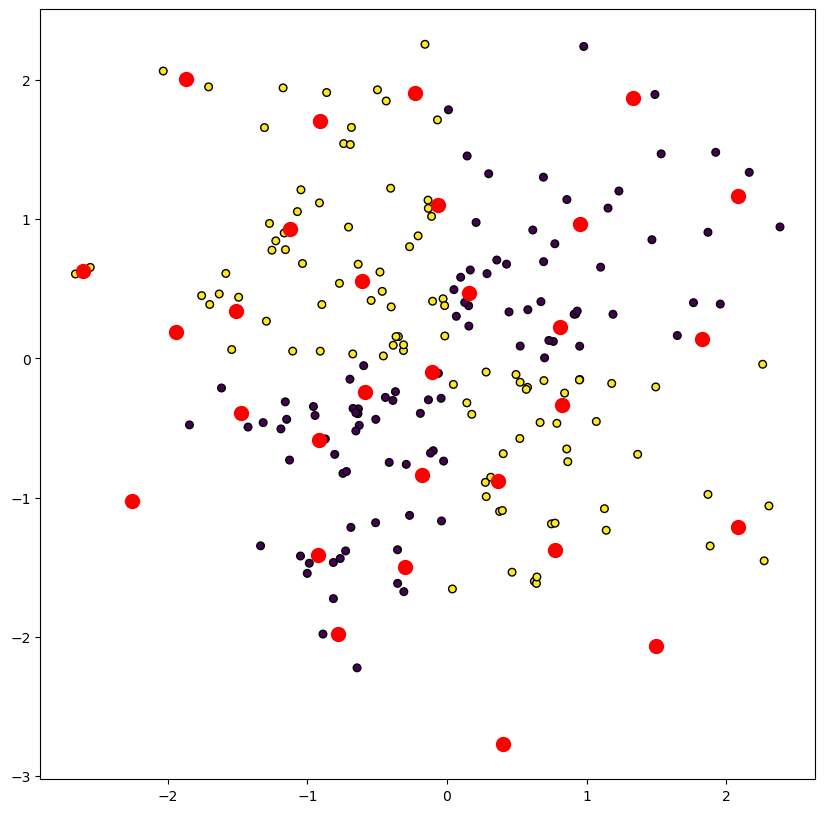

In [292]:
N = 30
print(X.shape) # (200, 2)
kmeans = KMeans(n_clusters=N,random_state=0).fit(X)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.viridis, edgecolors=(0, 0, 0))
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s=100, c='red' )

In [293]:
##### START YOUR CODE
s = 1.5 # kernel width (play with this parameter)

# Build the kernel matrix with the kmeans cluster centers
pairwise_distances = cdist(X, kmeans.cluster_centers_, metric='euclidean')
K = np.exp(-pairwise_distances ** 2 / (2 * s ** 2))

# Build a logistic model on the kernel matrix
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(K, y)

# Build a kernel representation of the test points with the kmeans cluster centers
test_pairwise_distances = cdist(test_points, kmeans.cluster_centers_, metric='euclidean')
test_kernel_matrix = np.exp(-test_pairwise_distances ** 2 / (2 * s ** 2))

# Predict probabilities on the test points
Z = logistic_regression_model.predict_proba(test_kernel_matrix)

##### END YOUR CODE
Z = Z[:, 1]
Z = Z.reshape(xx.shape)


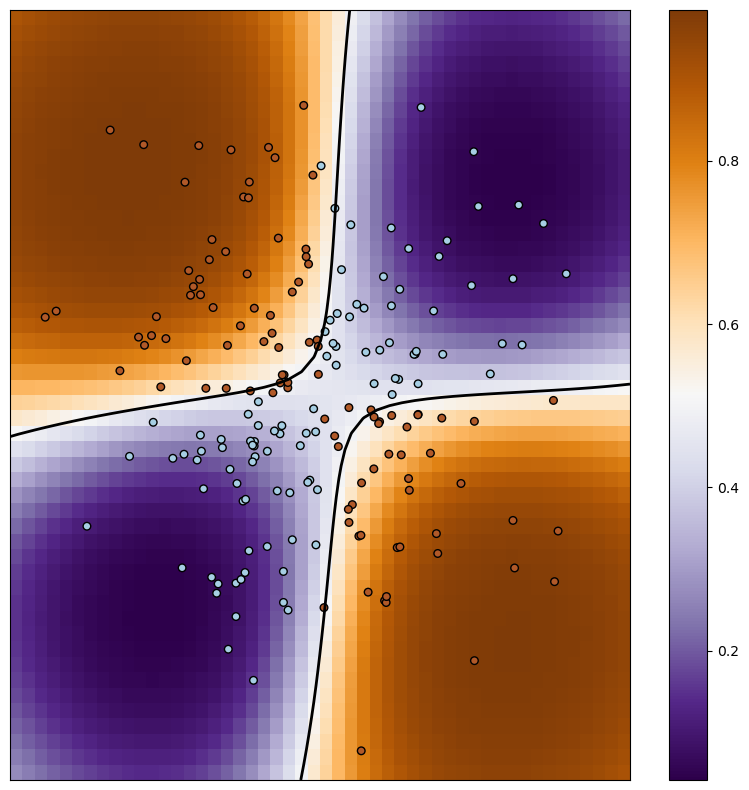

In [294]:
plot_boundary(Z,X,y,xx,yy)

## Kernel regression with strategically chosen kernels
- Use the specified centers as landmarks for building the kernel representation. That is, construct the kernel matrix K (hint: the function cdist in scipy.spatial.distance might be helpful). Ignore the bias term (column of 1s) in the construction of K. So K will be of size 4 x 4.
- build a logistic regresion model using K as your data matrix and y as your label vector
- construct the kernel matrix corresponding to the test points using the training set landmarks
- predict class probabilities for the test points
- reshape the predicted values array into a 50x50 grid
- plot the decision boundary using the given function

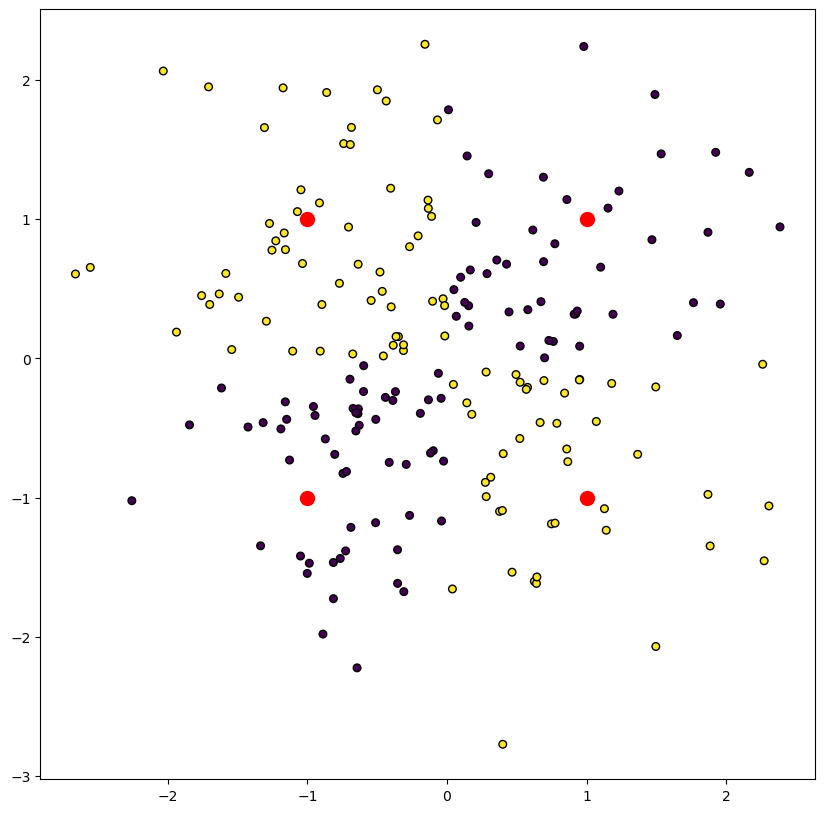

In [295]:
centers = np.array([[-1,-1],[-1,1],[1,-1],[1,1]])
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.viridis, edgecolors=(0, 0, 0))
plt.scatter(centers[:,0],centers[:,1], s=100, c='red' )

In [296]:
#### START YOUR CODE

s = 1.5 # kernel width (play with this parameter)

# Build the kernel matrix with respect to the new landmarks
pairwise_distances = cdist(X, centers, metric='euclidean')
K = np.exp(-pairwise_distances ** 2 / (2 * s ** 2))

# Build a logistic model on the kernel matrix
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(K, y)

# Build a kernel representation of the test points
test_pairwise_distances = cdist(test_points, centers, metric='euclidean')
test_kernel_matrix = np.exp(-test_pairwise_distances ** 2 / (2 * s ** 2))

# Predict class probabilities on the test points
Z = logistic_regression_model.predict_proba(test_kernel_matrix)

#### END YOUR CODE

# Reshape the predicted values array into a 50x50 grid
Z = Z[:, 1]
Z = Z.reshape(xx.shape)

# Comment on the results above
- how does landmark choice affect the quality of the decision boundary learned?

    Using random data points as landmarks did not smoothly catch the underlying structure very well. And considering this wasn't any complex dataset, it could pose more problems when the data is more sporadic and not perfectly randomly chosen. Using K-means cluster centers as the landmarks was more effective since the clusters aligned well with class boundaries. This also worked well with higher number of clusters, as it was better able to separate the data. And finally, manually selecting landmarks was definitely the best strategy in this case as it allowed us to choose a centroid point in each of the quadrants. This allowed the kernel regression to separate the data even more cleanly, even capturing the top right and bottom left upper/lower boundaries. I imagine that this strategy though isn't always the most useful since manually desginating the clusters could be more difficult with a more complex dataset. The decision of landmarks greatly affects the quality of the boundary.


- how does the choice of kernel width affect the quality of the decision boundary learned?

    Choosing a proper width is cruicial to getting a good decision boundary. When i played with the width, if I made the width too small, then the kernel regression greatly overfit the data and the decision boundaries. If I made the kernel width too large, then the kernel regression was not able to capture any proper relationship between the data or set up any right boundary.


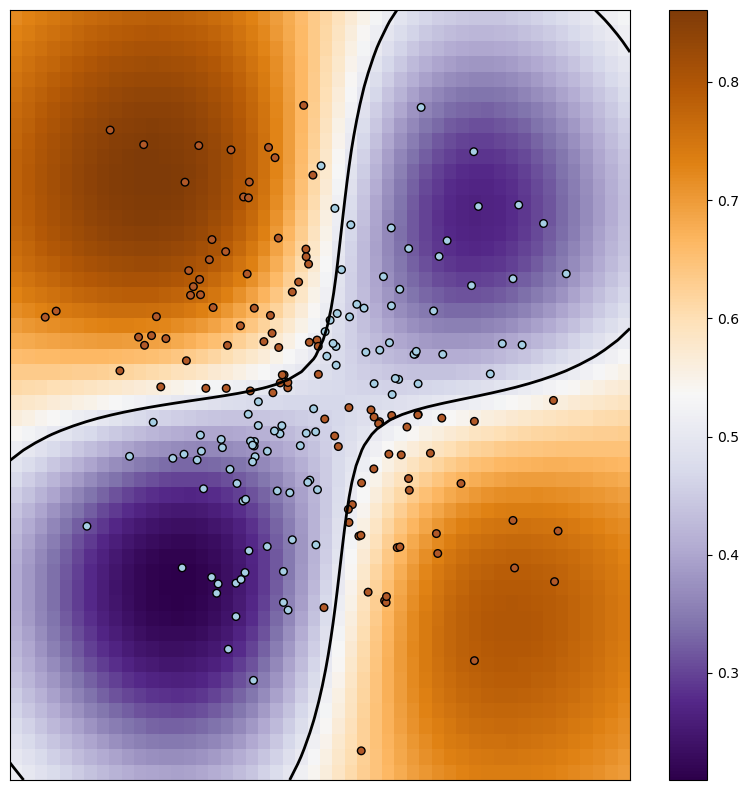

In [297]:
plot_boundary(Z,X,y,xx,yy)